# Graph regularization for sentiment classification using synthesized graphs

- What to do if natural graph is not available ?

- Create a graph from the data. Synthesize the graph from the data

# Recipe

The general recipe for building a graph-regularized model using the Neural Structured Learning (NSL) framework when the input does not contain an explicit graph is as follows:

- Create embeddings for each text sample in the input. This can be done using pre-trained models such as word2vec, Swivel, BERT etc.

- Build a graph based on these embeddings by using a similarity metric such as the 'L2' distance, 'cosine' distance, etc. Nodes in the graph correspond to samples and edges in the graph correspond to similarity between pairs of samples.

- Generate training data from the above synthesized graph and sample features. The resulting training data will contain neighbor features in addition to the original node features.

- Create a neural network as a base model using the Keras sequential, functional, or subclass API.

- Wrap the base model with the GraphRegularization wrapper class, which is provided by the NSL framework, to create a new graph Keras model. This new model will include a graph regularization loss as the regularization term in its training objective.
Train and evaluate the graph Keras model.


In [0]:
%tensorflow_version 2.x

In [2]:
! pip install --quiet neural-structured-learning
! pip install --quiet tensorflow-hub

     |████████████████████████████████| 112kB 7.4MB/s 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

import neural_structured_learning as nsl

import tensorflow as tf
tf.compat.v1.enable_v2_behavior()

import tensorflow_hub as hub

# Resets notebook state
tf.keras.backend.clear_session()

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")


Version:  2.2.0-rc2
Eager mode:  True
Hub version:  0.7.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


# Get the data

The IMDB dataset contains the text of 50,000 movie reviews from the Internet Movie Database. These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are balanced, meaning they contain an equal number of positive and negative reviews.

The IMDB dataset comes packaged with TensorFlow. It has already been preprocessed such that the reviews (sequences of words) have been converted to sequences of integers, where each integer represents a specific word in a dictionary.

The following code downloads the IMDB dataset (or uses a cached copy if it has already been downloaded):

In [4]:
imdb = tf.keras.datasets.imdb
(pp_train_data, pp_train_labels), (pp_test_data, pp_test_labels) = (
    imdb.load_data(num_words=10000))

17465344/17464789 [==============================] - 0s 0us/step


The argument num_words=10000 keeps the top 10,000 most frequently occurring words in the training data. The rare words are discarded to keep the size of the vocabulary manageable.

## Explore the data

Let's take a moment to understand the format of the data. The dataset comes preprocessed: each example is an array of integers representing the words of the movie review. Each label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

In [5]:
print('Training entries: {}, labels: {}'.format(
    len(pp_train_data), len(pp_train_labels)))
training_samples_count = len(pp_train_data)


Training entries: 25000, labels: 25000


The text of reviews have been converted to integers, where each integer represents a specific word in a dictionary. Here's what the first review looks like:

In [6]:
print(pp_train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


Movie reviews may be different lengths. The below code shows the number of words in the first and second reviews. Since inputs to a neural network must be the same length, we'll need to resolve this later.

## Convert the integers back to words

It may be useful to know how to convert integers back to the corresponding text. Here, we'll create a helper function to query a dictionary object that contains the integer to string mapping:

In [7]:
def build_reverse_word_index():
  # A dictionary mapping words to an integer index
  word_index = imdb.get_word_index()

  # The first indices are reserved
  word_index = {k: (v + 3) for k, v in word_index.items()}
  word_index['<PAD>'] = 0
  word_index['<START>'] = 1
  word_index['<UNK>'] = 2  # unknown
  word_index['<UNUSED>'] = 3
  return dict((value, key) for (key, value) in word_index.items())

reverse_word_index = build_reverse_word_index()

def decode_review(text):
  return ' '.join([reverse_word_index.get(i, '?') for i in text])


1646592/1641221 [==============================] - 0s 0us/step


In [0]:
reverse_word_index = build_reverse_word_index()

In [0]:
def decode_review(text):
  return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [10]:
decode_review(pp_train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

# Constructing the graph

Graph construction involves creating embeddings for text samples and then using a similarity function to compare the embeddings.

In [0]:
! mkdir -p /tmp/imdb

In [0]:
# This is necessary because hub.KerasLayer assumes tensor hashability, which
# is not supported in eager mode.
tf.compat.v1.disable_tensor_equality()

## Create sample embeddings

We will use pretrained Swivel embeddings to create embeddings in the tf.train.Example format for each sample in the input. We will store the resulting embeddings in the TFRecord format along with an additional feature that represents the ID of each sample. This is important and will allow us match sample embeddings with corresponding nodes in the graph later.

In [0]:
pretrained_embedding = 'https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1'
hub_layer = hub.KerasLayer(pretrained_embedding, input_shape=[], dtype=tf.string, trainable=True)

In [0]:
def _int64_feature(value):
  """Returns int64 tf.train.Feature."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value.tolist()))


def _bytes_feature(value):
  """Returns bytes tf.train.Feature."""
  return tf.train.Feature(
      bytes_list=tf.train.BytesList(value=[value.encode('utf-8')]))


def _float_feature(value):
  """Returns float tf.train.Feature."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=value.tolist()))

In [0]:
def create_embedding_example(word_vector, record_id):
    """Create tf.Example containing the sample's embedding and its ID."""
    # We build from text not from tokens
    text = decode_review(word_vector)
    # Remove the batch_size
    text = tf.reshape(text, shape=[-1, ])

    # Use the swivel embedding layer here to create embeddings from the text.
    sentence_emedding = hub_layer(text)

    # Embedding is 2D we need 1D
    sentence_emedding = tf.reshape(sentence_emedding, shape=[-1])

    features = {
        'id' : _bytes_feature(str(record_id)),
        'embedding' : _float_feature(sentence_emedding.numpy())
    }

    return tf.train.Example(features=tf.train.Features(feature=features))
    

In [0]:
def create_embeddings(word_vectors, output_path, starting_record_id):
    record_id = int(starting_record_id)
    with tf.io.TFRecordWriter(output_path) as writer:
        for word_vector in word_vectors:
            example = create_embedding_example(word_vector, record_id)
            record_id += 1
            writer.write(example.SerializeToString())
    
    return record_id


In [17]:
# Persist TF.Example features containing embeddings for training data in
# TFRecord format.
create_embeddings(pp_train_data, '/tmp/imdb/embeddings.tfr', 0)

25000

# Build The Graph

Now that we have the sample embeddings, we will use them to build a similarity graph, i.e, nodes in this graph will correspond to samples and edges in this graph will correspond to similarity between pairs of nodes.

Neural Structured Learning provides a graph building library to build a graph based on sample embeddings. It uses cosine similarity as the similarity measure to compare embeddings and build edges between them. It also allows us to specify a similarity threshold, which can be used to discard dissimilar edges from the final graph. In this example, using 0.99 as the similarity threshold, we end up with a graph that has 445,327 bi-directional edges.

In [0]:
nsl.tools.build_graph(embedding_files=['../tmp/imdb/embeddings.tfr'], 
                      output_graph_path='../tmp/imdb/graph_99.tsv', similarity_threshold=0.99)

Note: Graph quality and by extension, embedding quality, are very important for graph regularization. While we have used Swivel embeddings in this notebook, using BERT embeddings for instance, will likely capture review semantics more accurately. We encourage users to use embeddings of their choice and as appropriate to their needs.

# Create the neighbors for the graphs

We create sample features for our problem using the tf.train.Example format and persist them in the TFRecord format. Each sample will include the following three features:

    id: The node ID of the sample.
    words: An int64 list containing word IDs.
    label: A singleton int64 identifying the target class of the review.


In [0]:
def create_example(word_vector, label, record_id):
  """Create tf.Example containing the sample's word vector, label, and ID."""
  features = {
      'id': _bytes_feature(str(record_id)),
      'words': _int64_feature(np.asarray(word_vector)),
      'label': _int64_feature(np.asarray([label])),
  }
  return tf.train.Example(features=tf.train.Features(feature=features))

In [0]:
def create_records(word_vectors, labels, record_path, starting_record_id):
    record_id = int(starting_record_id)
    with tf.io.TFRecordWriter(record_path) as writer:
        for word_vector, label in zip(word_vectors, labels):
            example = create_example(word_vector, label, record_id)
            record_id += 1
            writer.write(example.SerializeToString())
    return record_id

In [21]:
next_record_id = create_records(pp_train_data, pp_train_labels,
                                '/tmp/imdb/train_data.tfr', 0)

create_records(pp_test_data, pp_test_labels, '/tmp/imdb/test_data.tfr',
               next_record_id)


50000

# Augment training data with graph neighbors

Since we have the sample features and the synthesized graph, we can generate the augmented training data for Neural Structured Learning. 

The NSL framework provides a library to combine the graph and the sample features to produce the final training data for graph regularization. 

The resulting training data will include original sample features as well as features of their corresponding neighbors.

In this tutorial, we consider undirected edges and use a maximum of 3 neighbors per sample to augment training data with graph neighbors.

In [0]:
nsl.tools.pack_nbrs(
    labeled_examples_path ='/tmp/imdb/train_data.tfr',
    unlabeled_examples_path = '',
    graph_path='/tmp/imdb/graph_99.tsv', 
    output_training_data_path='/tmp/imdb/nsl_train_data.tfr',
    add_undirected_edges=True,
    max_nbrs=3, )

We are now ready to build a base model without graph regularization. In order to build this model, we can either use embeddings that were used in building the graph, or we can learn new embeddings jointly along with the classification task. For the purpose of this notebook, we will do the latter.

In [0]:
NBR_FEATURE_PREFIX = 'NL_nbr_'
NBR_WEIGHT_SUFFIX = '_weight'

# Hyperparameters

We will use an instance of HParams to inclue various hyperparameters and constants used for training and evaluation. We briefly describe each of them below:




    num_classes: There are 2 classes -- positive and negative.

    max_seq_length: This is the maximum number of words considered from each movie review in this example.

    vocab_size: This is the size of the vocabulary considered for this example.

    distance_type: This is the distance metric used to regularize the sample with its neighbors.

    graph_regularization_multiplier: This controls the relative weight of the graph regularization term in the overall loss function.

    num_neighbors: The number of neighbors used for graph regularization. This value has to be less than or equal to the max_nbrs argument used above when invoking nsl.tools.pack_nbrs.

    num_fc_units: The number of units in the fully connected layer of the neural network.

    train_epochs: The number of training epochs.

    batch_size: Batch size used for training and evaluation.

    eval_steps: The number of batches to process before deeming evaluation is complete. If set to None, all instances in the test set are evaluated.

In [0]:
class HParams(object):
  """Hyperparameters used for training."""
  def __init__(self):
    ### dataset parameters
    self.num_classes = 2
    self.max_seq_length = 256
    self.vocab_size = 10000
    ### neural graph learning parameters
    self.distance_type = nsl.configs.DistanceType.L2
    self.graph_regularization_multiplier = 0.1
    self.num_neighbors = 2
    ### model architecture
    self.num_embedding_dims = 16
    self.num_lstm_dims = 64
    self.num_fc_units = 64
    ### training parameters
    self.train_epochs = 10
    self.batch_size = 128
    ### eval parameters
    self.eval_steps = None  # All instances in the test set are evaluated.

HPARAMS = HParams()


# Prepare the Data

The reviews—the arrays of integers—must be converted to tensors before being fed into the neural network. This conversion can be done a couple of ways:

- Convert the arrays into vectors of 0s and 1s indicating word occurrence, similar to a one-hot encoding. For example, the sequence [3, 5] would become a 10000-dimensional vector that is all zeros except for indices 3 and 5, which are ones. Then, make this the first layer in our network—a Dense layer—that can handle floating point vector data. This approach is memory intensive, though, requiring a num_words * num_reviews size matrix.

- Alternatively, we can pad the arrays so they all have the same length, then create an integer tensor of shape max_length * num_reviews. We can use an embedding layer capable of handling this shape as the first layer in our network.


we will use the second approach.

Since the movie reviews must be the same length, we will use the pad_sequence function defined below to standardize the lengths.

In [0]:
def pad_sequence(sequence, max_seq_length):
    """Pads the input sequence (a `tf.SparseTensor`) to `max_seq_length`."""
    pad_size = tf.maximum([0], max_seq_length - tf.shape(sequence)[0])
    padded = tf.concat(
        [sequence.values,
        tf.fill((pad_size), tf.cast(0, sequence.dtype))],
        axis=0)
    # The input sequence may be larger than max_seq_length. Truncate down if
    # necessary.
    return tf.slice(padded, [0], [max_seq_length])


In [0]:
def parse_example(example_proto):
    """Extracts relevant fields from the `example_proto`.

    Args:
    example_proto: An instance of `tf.train.Example`.

    Returns:
    A pair whose first value is a dictionary containing relevant features
    and whose second value contains the ground truth labels.
    """
    # The 'words' feature is a variable length word ID vector.
    feature_spec = {
        'words': tf.io.VarLenFeature(tf.int64),
        'label': tf.io.FixedLenFeature((), tf.int64, default_value=-1),
    }
    # We also extract corresponding neighbor features in a similar manner to
    # the features above.
    for i in range(HPARAMS.num_neighbors):
        nbr_feature_key = '{}{}_{}'.format(NBR_FEATURE_PREFIX, i, 'words')
        nbr_weight_key = '{}{}{}'.format(NBR_FEATURE_PREFIX, i, NBR_WEIGHT_SUFFIX)
        feature_spec[nbr_feature_key] = tf.io.VarLenFeature(tf.int64)

    # We assign a default value of 0.0 for the neighbor weight so that
    # graph regularization is done on samples based on their exact number
    # of neighbors. In other words, non-existent neighbors are discounted.
        feature_spec[nbr_weight_key] = tf.io.FixedLenFeature(
            [1], tf.float32, default_value=tf.constant([0.0]))

    features = tf.io.parse_single_example(example_proto, feature_spec)

    # Since the 'words' feature is a variable length word vector, we pad it to a
    # constant maximum length based on HPARAMS.max_seq_length
    features['words'] = pad_sequence(features['words'], HPARAMS.max_seq_length)
    for i in range(HPARAMS.num_neighbors):
        nbr_feature_key = '{}{}_{}'.format(NBR_FEATURE_PREFIX, i, 'words')
        features[nbr_feature_key] = pad_sequence(features[nbr_feature_key],
                                                    HPARAMS.max_seq_length)

    labels = features.pop('label')
    return features, labels

In [0]:
def make_dataset(file_path, training=False):
    """Creates a `tf.data.TFRecordDataset`.

    Args:
    file_path: Name of the file in the `.tfrecord` format containing
        `tf.train.Example` objects.
    training: Boolean indicating if we are in training mode.

    Returns:
    An instance of `tf.data.TFRecordDataset` containing the `tf.train.Example`
    objects.
    """
    dataset = tf.data.TFRecordDataset([file_path])
    if training:
        dataset = dataset.shuffle(10000)
    dataset = dataset.map(parse_example)
    dataset = dataset.batch(HPARAMS.batch_size)
    return dataset

In [0]:
train_dataset = make_dataset('/tmp/imdb/nsl_train_data.tfr', True)
test_dataset = make_dataset('/tmp/imdb/test_data.tfr')

# Build the model

In [0]:
# This function exists as an alternative to the bi-LSTM model used in this
# notebook.
def make_feed_forward_model():
    """Builds a simple 2 layer feed forward neural network."""
    inputs = tf.keras.Input(
        shape=(HPARAMS.max_seq_length,), dtype='int64', name='words')
    embedding_layer = tf.keras.layers.Embedding(HPARAMS.vocab_size, 16)(inputs)
    pooling_layer = tf.keras.layers.GlobalAveragePooling1D()(embedding_layer)
    dense_layer = tf.keras.layers.Dense(16, activation='relu')(pooling_layer)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense_layer)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

# Feel free to use an architecture of your choice.

In [0]:
def make_bilstm_model():
    """Builds a bi-directional LSTM model."""
    inputs = tf.keras.Input(
        shape=(HPARAMS.max_seq_length,), dtype='int64', name='words')
    embedding_layer = tf.keras.layers.Embedding(HPARAMS.vocab_size,
                                                HPARAMS.num_embedding_dims)(
                                                    inputs)
    lstm_layer = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(HPARAMS.num_lstm_dims))(
            embedding_layer)
    dense_layer = tf.keras.layers.Dense(
        HPARAMS.num_fc_units, activation='relu')(
            lstm_layer)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense_layer)
    return tf.keras.Model(inputs=inputs, outputs=outputs)


In [0]:
model = make_bilstm_model()

In [0]:
model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Create a validation set

In [64]:
validation_fraction = 0.9
validation_size = int(validation_fraction *
                      int(training_samples_count / HPARAMS.batch_size))
print(validation_size)
validation_dataset = train_dataset.take(validation_size)
train_dataset = train_dataset.skip(validation_size)

175


In [0]:
#  Train the model

In [0]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=HPARAMS.train_epochs,
    verbose=1)


In [67]:
results = model.evaluate(test_dataset, steps=HPARAMS.eval_steps)
print(results)

196/196 [==============================] - 4s 20ms/step - loss: 0.6934 - accuracy: 0.5000
[0.6934233903884888, 0.5]


In [68]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

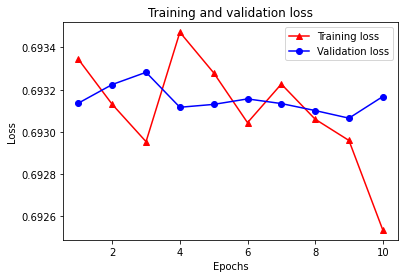

In [69]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "-r^" is for solid red line with triangle markers.
plt.plot(epochs, loss, '-r^', label='Training loss')
# "-b0" is for solid blue line with circle markers.
plt.plot(epochs, val_loss, '-bo', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

# Graph regularization


We are now ready to try graph regularization using the base model that we built above. We will use the GraphRegularization wrapper class provided by the Neural Structured Learning framework to wrap the base (bi-LSTM) model to include graph regularization. The rest of the steps for training and evaluating the graph-regularized model are similar to that of the base model.

## Create graph-regularized model

To assess the incremental benefit of graph regularization, we will create a new base model instance. This is because model has already been trained for a few iterations, and reusing this trained model to create a graph-regularized model will not be a fair comparison for model.

In [0]:
# Build a new base LSTM model.
base_reg_model = make_bilstm_model()

In [0]:
graph_reg_config = nsl.configs.make_graph_reg_config(max_neighbors=HPARAMS.num_neighbors,
                                                    multiplier=HPARAMS.graph_regularization_multiplier,
                                                     distance_type=HPARAMS.distance_type,
                                                     sum_over_axis=-1)

In [0]:
graph_reg_model = nsl.keras.GraphRegularization(base_model=base_reg_model, graph_reg_config=graph_reg_config)

In [0]:
graph_reg_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])

In [76]:
graph_reg_history = graph_reg_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=HPARAMS.train_epochs,
    verbose=1)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


21/21 [==============================] - 48s 2s/step - loss: 0.6933 - acc: 0.4892 - graph_loss: 3.1436e-06 - val_loss: 0.6927 - val_acc: 0.5074 - val_graph_loss: 0.0000e+00
Epoch 2/10
21/21 [==============================] - 45s 2s/step - loss: 0.6916 - acc: 0.5231 - graph_loss: 4.6051e-05 - val_loss: 0.6876 - val_acc: 0.5022 - val_graph_loss: 0.0000e+00
Epoch 3/10
21/21 [==============================] - 45s 2s/step - loss: 0.6517 - acc: 0.6488 - graph_loss: 0.0158 - val_loss: 0.6118 - val_acc: 0.7396 - val_graph_loss: 0.0000e+00
Epoch 4/10
21/21 [==============================] - 45s 2s/step - loss: 0.5307 - acc: 0.7508 - graph_loss: 0.0650 - val_loss: 0.4788 - val_acc: 0.7643 - val_graph_loss: 0.0000e+00
Epoch 5/10
21/21 [==============================] - 45s 2s/step - loss: 0.4391 - acc: 0.8131 - graph_loss: 0.1195 - val_loss: 0.4858 - val_acc: 0.7909 - val_graph_loss: 0.0000e+00
Epoch 6/10
21/21 [==============================] - 46s 2s/step - loss: 0.4297 - acc: 0.8269 - graph_lo

In [77]:
graph_reg_results = graph_reg_model.evaluate(test_dataset, steps=HPARAMS.eval_steps)
print(graph_reg_results)

196/196 [==============================] - 4s 22ms/step - loss: 0.3943 - acc: 0.8255 - graph_loss: 0.0000e+00
[0.3943191468715668, 0.8254799842834473, 0.0]


In [0]:
graph_reg_history_dict = graph_reg_history.history
graph_reg_history_dict.keys()
acc = graph_reg_history_dict['acc']
val_acc = graph_reg_history_dict['val_acc']
loss = graph_reg_history_dict['loss']
graph_loss = graph_reg_history_dict['graph_loss']
val_loss = graph_reg_history_dict['val_loss']
val_graph_loss = graph_reg_history_dict['val_graph_loss']

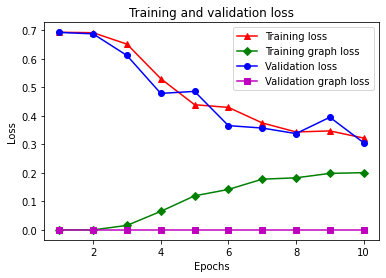

In [81]:
epochs = range(1, len(acc) + 1)
# plt.clf()   # clear figure
# "-r^" is for solid red line with triangle markers.
plt.plot(epochs, loss, '-r^', label='Training loss')
# "-gD" is for solid green line with diamond markers.
plt.plot(epochs, graph_loss, '-gD', label='Training graph loss')
# "-b0" is for solid blue line with circle markers.
plt.plot(epochs, val_loss, '-bo', label='Validation loss')
# "-ms" is for solid magenta line with square markers.
plt.plot(epochs, val_graph_loss, '-ms', label='Validation graph loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

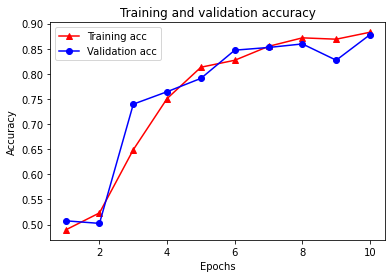

In [82]:
plt.plot(epochs, acc, '-r^', label='Training acc')
plt.plot(epochs, val_acc, '-bo', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()


# About Semi Supervised Learning

Semi-supervised learning and more specifically, graph regularization in the context of this tutorial, can be really powerful when the amount of training data is small. 

The lack of training data is compensated by leveraging similarity among the training samples, which is not possible in traditional supervised learning.

We define supervision ratio as the ratio of training samples to the total number of samples which includes training, validation, and test samples. 

In this notebook, we have used a supervision ratio of 0.05 (i.e, 5% of the labeled data) for training both the base model as well as the graph-regularized model. We illustrate the impact of the supervision ratio on model accuracy in the cell below.

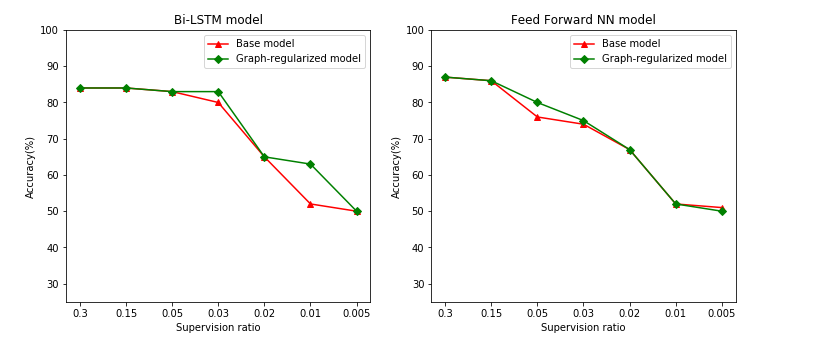

It can be observed that as the superivision ratio decreases, model accuracy also decreases. 

This is true for both the base model and for the graph-regularized model, regardless of the model architecture used. 

However, notice that the graph-regularized model performs better than the base model for both the architectures. In particular, for the Bi-LSTM model, when the supervision ratio is 0.01, the accuracy of the graph-regularized model is ~20% higher than that of the base model. 

This is primarily because of semi-supervised learning for the graph-regularized model, where structural similarity among training samples is used in addition to the training samples themselves.